# Face detection (light)

• Blaze Face (https://arxiv.org/pdf/1907.05047)
• Swift Face (https://www.researchgate.net/publication/344422660_SwiftFace_Real-Time_Face_Detection)
• Yolo5Face (https://arxiv.org/pdf/2105.12931)
• UltraFace (https://ieeexplore.ieee.org/document/10763901)

git :
https://github.com/vincent1bt/blazeface-tensorflow/blob/main/model_blocks.py

papers:
https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec
https://fr.wikipedia.org/wiki/Max_pooling#:~:text=En%20apprentissage%20automatique%2C%20la%20couche,par%20un%20réseau%20de%20neurones.
https://ai.google.dev/edge/mediapipe/solutions/vision/face_detector#blazeface_short-range

In [1]:
import tensorflow as tf
from anyio.lowlevel import checkpoint
from tensorflow.keras import layers
from tensorflow.python.util.tf_export import kwarg_only
tf.config.run_functions_eagerly(True)

print(tf.__version__, tf.config.list_physical_devices('GPU'))

import os
import time
import argparse
parser = argparse.ArgumentParser()

2026-01-16 14:40:29.708731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 14:40:29.744418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 14:40:30.830945: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. T

AttributeError: _ARRAY_API not found

2.20.0 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Block

In [2]:
class BlazeBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, use_pool=True, **kwargs):
        super(BlazeBlock, self).__init__(**kwargs)
        self.strides = strides
        self.filters = filters
        self.use_pool = use_pool

        if use_pool:
            self.skip = layers.MaxPool2D(pool_size=2, strides=strides, padding='same')
            self.channel_pad = layers.Lambda(lambda x: self._pad_channels(x, filters))

        self.dw_conv = layers.DepthwiseConv2D((5, 5), strides=strides, padding='same')
        self.conv = layers.Conv2D(filters, (1, 1), strides=(1, 1))

        self.norm_1 = layers.BatchNormalization()
        self.norm_2 = layers.BatchNormalization()

        self.activation = layers.ReLU()

    def _pad_channels(self, x, target_channels):
        current_channels = x.shape[-1]
        if current_channels is None:
            return x

        channels_to_add = target_channels - current_channels
        if channels_to_add <= 0:
            return x

        paddings = [[0, 0], [0, 0], [0, 0], [0, channels_to_add]]
        return tf.pad(x, paddings, mode='CONSTANT', constant_values=0)

    
    def call(self, inputs, training=False):
        x = self.dw_conv(inputs)
        x = self.norm_1(x)
        x = self.conv(x)
        x = self.norm_2(x)

        if self.use_pool:
            skip = self.skip(inputs)
            skip = self.channel_pad(skip)
            x = x + skip

        x = self.activation(x)
        return x
    
class DoubleBlazeBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides, use_pool = True, **kwargs):
        super(DoubleBlazeBlock, self).__init__(**kwargs)

        self.filters = filters
        self.strides = strides
        self.use_pool = use_pool

        if use_pool:
            self.skip = layers.MaxPool2D(pool_size=2, strides=strides, padding='same')
            self.channel_pad = layers.Lambda(lambda x: self._pad_channels(x, filters))
        
        self.dw_conv_1 = layers.DepthwiseConv2D((5, 5), strides=strides, padding='same')
        self.dw_conv_2 = layers.DepthwiseConv2D((5, 5), strides=(1, 1), padding='same')

        self.conv_project = layers.Conv2D(self.filters, (1, 1), strides=(1, 1))
        self.conv_expand = layers.Conv2D(self.filters, (1, 1), strides=(1, 1))

        self.norm_1 = layers.BatchNormalization()
        self.norm_2 = layers.BatchNormalization()
        self.norm_3 = layers.BatchNormalization()
        self.norm_4 = layers.BatchNormalization()

        self.activation_1 = layers.ReLU()
        self.activation_2 = layers.ReLU()

    def _pad_channels(self, x, target_channels):
        current_channels = x.shape[-1]
        if current_channels is None:
            return x

        channels_to_add = target_channels - current_channels
        if channels_to_add <= 0:
            return x

        paddings = [[0, 0], [0, 0], [0, 0], [0, channels_to_add]]
        return tf.pad(x, paddings, mode='CONSTANT', constant_values=0)

    def call(self, inputs, training = False):
        x = self.dw_conv_1(inputs)
        x = self.norm_1(x)
        x = self.conv_project(x)
        x = self.norm_2(x)

        x = self.activation_1(x)

        x = self.dw_conv_2(x)
        x = self.norm_3(x)
        x = self.conv_expand(x)
        x = self.norm_4(x)

        if self.use_pool:
            skip = self.skip(inputs)
            skip = self.channel_pad(skip)
            x = x + skip

        x = self.activation_2(x)

        return x


## Model

In [3]:
class BlazeModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(BlazeModel, self).__init__(**kwargs)

        self.conv = layers.Conv2D(24, (5, 5), strides=2, padding='same')
        self.activation = layers.ReLU()

        self.block1 = BlazeBlock(filters=24, strides=1)
        self.block2 = BlazeBlock(filters=24, strides=1)
        self.block3 = BlazeBlock(filters=48, strides=2)
        self.block4 = BlazeBlock(filters=48, strides=1)
        self.block5 = BlazeBlock(filters=48, strides=1)
        
        self.block6 = DoubleBlazeBlock(filters=96, strides=2)
        self.block7 = DoubleBlazeBlock(filters=96, strides=1)
        self.block8 = DoubleBlazeBlock(filters=96, strides=1)
        self.block9 = DoubleBlazeBlock(filters=96, strides=2)
        self.block10 = DoubleBlazeBlock(filters=96, strides=1)
        self.block11 = DoubleBlazeBlock(filters=96, strides=1)

        self.classifier_8 = layers.Conv2D(2, (1, 1), strides=(1, 1), activation='sigmoid')
        self.classifier_16 = layers.Conv2D(6, (1, 1), strides=(1, 1), activation='sigmoid')

        self.regressor_8 = layers.Conv2D(8, (1, 1), strides=(1, 1))
        self.regressor_16 = layers.Conv2D(24, (1, 1), strides=(1, 1))

    def call(self, inputs):
        # tf.print("Input size conv:", tf.shape(inputs))
        x = self.conv(inputs)
        # tf.print("Input size ReLu:", tf.shape(x))
        x = self.activation(x)


        # tf.print("Input size Single BlazeBlock_1:", tf.shape(x))
        x = self.block1(x)
        # tf.print("Input size Single BlazeBlock_2:", tf.shape(x))
        x = self.block2(x)
        # tf.print("Input size Single BlazeBlock_3:", tf.shape(x))
        x = self.block3(x)
        # tf.print("Input size Single BlazeBlock_4:", tf.shape(x))
        x = self.block4(x)
        # tf.print("Input size Single BlazeBlock_5:", tf.shape(x))
        x = self.block5(x)

        # tf.print("Input size Double BlazeBlock_1:", tf.shape(x))
        x = self.block6(x)
        # tf.print("Input size Double BlazeBlock_2:", tf.shape(x))
        x = self.block7(x)
        # tf.print("Input size Double BlazeBlock_3:", tf.shape(x))
        x = self.block8(x)
        # tf.print("Input size Double BlazeBlock_4:", tf.shape(x))
        h = self.block9(x)
        # tf.print("Input size Double BlazeBlock_5:", tf.shape(h))
        h = self.block10(h)
        # tf.print("Input size Double BlazeBlock_6:", tf.shape(h))
        h = self.block11(h)

        # tf.print("Input size classifier_8:", tf.shape(x))
        c1 = self.classifier_8(x)
        # tf.print("Input size reshape:", tf.shape(c1))
        c1 = layers.Reshape((-1, 1))(c1)

        # tf.print("Input size classifier_16:", tf.shape(h))
        c2 = self.classifier_16(h)
        # tf.print("Input size reshape:", tf.shape(c2))
        c2 = layers.Reshape((-1, 1))(c2)

        c = layers.concatenate([c1, c2], axis = 1)
        # tf.print("Output size classifier_concat:", tf.shape(c))

        # tf.print("Input size regressor_8:", tf.shape(x))
        r1 = self.regressor_8(x)
        # tf.print("Input size reshape:", tf.shape(r1))
        r1 = layers.Reshape((-1, 4))(r1)

        # tf.print("Input size regressor_16:", tf.shape(h))
        r2 = self.regressor_16(h)
        # tf.print("Input size reshape:", tf.shape(r2))
        r2 = layers.Reshape((-1, 4))(r2)

        r = layers.concatenate([r1, r2], axis=1)
        # tf.print("Output size regressor_concat:", tf.shape(r))

        return c, r


# Loss

In [4]:
huber_loss = tf.keras.losses.Huber()

def compute_loss(class_prediction, anchor_predictions, big_anchors, small_anchors, reference_anchors, ratio=3, scale=128):
    B = big_anchors.shape[0]
    list_big_anchors = tf.reshape(big_anchors, (B, -1, 5))

    list_small_anchors = tf.reshape(small_anchors, (B, -1, 5))

    list_true_anchors = tf.concat([list_small_anchors, list_big_anchors], axis=1)

    true_classes = list_true_anchors[:, :, 0]
    true_coords = list_true_anchors[:, :, 1:]

    faces_mask_bool = tf.dtypes.cast(true_classes, tf.bool)

    faces_num = tf.keras.backend.sum(true_classes)
    background_num = int(faces_num * ratio)

    class_predictions = tf.squeeze(class_prediction, axis=-1)

    predicted_classes_scores = tf.where(faces_mask_bool, -99.0, class_predictions)

    background_class_predictions = tf.sort(predicted_classes_scores, axis=-1, direction='DESCENDING')[:, :background_num]
    positive_class_predictions = tf.boolean_mask(class_predictions, faces_mask_bool)

    background_loss = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(background_class_predictions), background_class_predictions))
    positive_loss = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(positive_class_predictions), positive_class_predictions))


    x_center = reference_anchors[:, 0:1] + (anchor_predictions[..., 0:1] / scale)
    y_center = reference_anchors[:, 1:2] + (anchor_predictions[..., 1:2] / scale)

    w = anchor_predictions[..., 2:3] / scale
    h = anchor_predictions[..., 3:4] / scale

    x_min = x_center - w / 2.
    y_min = y_center - h / 2.
    x_max = x_center + w / 2.
    y_max = y_center + h / 2.

    offset_boxes = tf.concat([x_min, y_min, x_max, y_max], axis=-1)

    filtered_true_coords = tf.boolean_mask(true_coords, faces_mask_bool)
    filtered_pred_coords = tf.boolean_mask(offset_boxes, faces_mask_bool)

    detection_loss = huber_loss(filtered_true_coords, filtered_pred_coords)

    loss = tf.math.reduce_mean(detection_loss) * 150 + (background_loss * 35) + (positive_loss * 35)

    return loss, filtered_pred_coords, filtered_true_coords, positive_class_predictions, background_class_predictions

# Utils

In [5]:
import numpy as np
import tensorflow as tf

small_boxes = np.linspace(0.03125, 0.96875, 16, endpoint=True, dtype=np.float32) # 16x16
big_boxes = np.linspace(0.0625, .9375, 8, endpoint=True, dtype=np.float32) # 8x8
list_of_boxes = [small_boxes, big_boxes]

small_x = tf.tile(tf.repeat(small_boxes, repeats=2), [16]) # x
small_y = tf.repeat(small_boxes, repeats=32)

small = tf.stack([small_x, small_y], axis=1)

big_x = tf.tile(tf.repeat(big_boxes, repeats=6), [8]) # x
big_y = tf.repeat(big_boxes, repeats=48)

big = tf.stack([big_x, big_y], axis=1)

reference_anchors = tf.concat([small, big], axis=0)

def mean_iou(true_boxes, pred_boxes, return_mean=True):
    x_min = tf.math.maximum(true_boxes[..., 0], pred_boxes[..., 0])
    y_min = tf.math.maximum(true_boxes[..., 1], pred_boxes[..., 1])
    x_max = tf.math.minimum(true_boxes[..., 2], pred_boxes[..., 2])
    y_max = tf.math.minimum(true_boxes[..., 3], pred_boxes[..., 3])

    overlap_area = tf.math.maximum(0.0, x_max - x_min + 1) * tf.math.maximum(0.0, y_max - y_min + 1)

    true_boxes_area = (true_boxes[..., 2] - true_boxes[..., 0] + 1) * (true_boxes[..., 3] - true_boxes[..., 1] + 1)

    predicted_boxes_area = (pred_boxes[..., 2] - pred_boxes[..., 0] + 1) * (pred_boxes[..., 3] - pred_boxes[..., 1] + 1)

    union_area = (true_boxes_area + predicted_boxes_area - overlap_area)

    if return_mean:
        return tf.math.reduce_mean(overlap_area / union_area)
    else:
        return overlap_area / union_area

def average_maximum_sup(class_predictions, anchor_predictions, reference_anchors, scale=128):
    # class_predictions # B, 896, 1
    # anchor_predictions # B, 896, 4

    x_center = reference_anchors[:, 0:1] + (anchor_predictions[..., 0:1] / scale) # 8, 896, 1
    y_center = reference_anchors[:, 1:2] + (anchor_predictions[..., 1:2] / scale) # 8, 896, 1

    w = anchor_predictions[..., 2:3] / scale # B, 896, 1
    h = anchor_predictions[..., 3:4] / scale # B, 896, 1

    y_min = y_center - h / 2.  # ymin
    x_min = x_center - w / 2.  # xmin
    y_max = y_center + h / 2.  # ymax
    x_max = x_center + w / 2.  # xmax

    offset_boxes = tf.concat([x_min, y_min, x_max, y_max], axis=-1) # B, 896, 4

    class_predictions = tf.squeeze(class_predictions, axis=-1)

    mask = class_predictions >= 0.75 # 0.75 B, 896

    final_detections = [] # final shape B, num_image_detections, 5 where num_image_detections can vary by image

    for index, image_detections in enumerate(mask): # each 896 for each image
        # print(image_detections)
        num_image_detections = tf.keras.backend.sum(tf.dtypes.cast(image_detections, tf.int32))
        # print(image_detections.shape)
        # print(num_image_detections)

        if num_image_detections == 0:
            final_detections.append([])
        else:
            filtered_boxes = tf.boolean_mask(offset_boxes[index], image_detections)
            filtered_scores = tf.boolean_mask(class_predictions[index], image_detections)

            final_detections.append(tf.concat([tf.expand_dims(filtered_scores, axis=-1), filtered_boxes], axis=-1)) # num_image_detections, 5

    output_detections = []

    for image_detections in final_detections: # for each image B
        # num_image_detections, 5
        if image_detections == []:
            output_detections.append([])
            continue

        remaining = tf.argsort(image_detections[:, 0], axis=0, direction='DESCENDING') # num_image_detections

        faces = []

        while remaining.shape[0] > 0:
            detection = image_detections[remaining[0]]
            first_box = detection[1:] # 1, 4
            other_boxes = tf.gather(image_detections, remaining)[:, 1:] # 4, 4

            ious = mean_iou(np.array(first_box) * 128.0, np.array(other_boxes) * 128.0, return_mean=False) # num_image_detections

            # mask = ious > 0.3 # 4

            overlapping = tf.boolean_mask(remaining, ious > 0.3)
            remaining = tf.boolean_mask(remaining, ious <= 0.3) # When all false, returns shape 0
            # The remaining boxes should belong to a different face

            if overlapping.shape[0] > 1:
                overlapping_boxes = tf.gather(image_detections, overlapping)
                coordinates = overlapping_boxes[:, 1:] # overlapping, 4
                scores = overlapping_boxes[:, 0:1] # overlapping, 1
                total_score = tf.keras.backend.sum(scores)

                weighted_boxes = tf.keras.backend.sum((coordinates * scores), axis=0) / total_score # overlapping, 4
                weighted_score = total_score / overlapping.shape[0] # overlapping, 1

                weighted_score = tf.reshape(weighted_score, (1,))

                weighted_detection = tf.concat([weighted_score, weighted_boxes], axis=0) # overlapping, 5

                faces.append(weighted_detection)

            else:
                faces.append(detection)

        output_detections.append(faces)

        return output_detections, final_detections


def order_big_anchors_randomly(big_anchors):
  big_anchor_list = []
  total_boxes = 30

  for batch_element in big_anchors: # B, 8, 8, 5
    box_index = tf.random.uniform([], 0, 6, dtype=tf.dtypes.int32) * 5 # 0, 5, 10, 15, 20, 25

    if box_index == 0:
      right_box = tf.zeros((8, 8, total_boxes - 5))

      anchor_tensor = tf.concat([batch_element, right_box], axis=-1)
      big_anchor_list.append(anchor_tensor)

    elif box_index == 25:
      left_box = tf.zeros((8, 8, total_boxes - 5))

      anchor_tensor = tf.concat([left_box, batch_element], axis=-1)
      big_anchor_list.append(anchor_tensor)

    else:
      left_box = tf.zeros((8, 8, box_index))
      right_box = tf.zeros((8, 8, total_boxes - box_index - 5))

      anchor_tensor = tf.concat([left_box, batch_element, right_box], axis=-1)
      big_anchor_list.append(anchor_tensor)


  big_anchor_list = tf.stack(big_anchor_list, axis=0) # B, 8, 8, 30

  return big_anchor_list


def order_small_anchors_randomly(small_anchors):
  small_anchor_list = []

  for batch_element in small_anchors: # B, 16, 16, 5
    box_index = tf.random.uniform([], 0, 2, dtype=tf.dtypes.int32) * 5 # 0, 5

    if box_index == 0:
      right_box = tf.zeros((16, 16, 5))

      anchor_tensor = tf.concat([batch_element, right_box], axis=-1)
      small_anchor_list.append(anchor_tensor)

    else:
      left_box = tf.zeros((16, 16, 5))

      anchor_tensor = tf.concat([left_box, batch_element], axis=-1)
      small_anchor_list.append(anchor_tensor)

  small_anchor_list = tf.stack(small_anchor_list, axis=0) # B, 16, 16, 10

  return small_anchor_list


I0000 00:00:1768570831.941671   31860 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6147 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# DataSet

In [6]:
import numpy as np
import pandas as pd
import cv2

def get_vertical_new_axes(params, final_image_size=128):
    boxes_width, boxes_height, height, width, vertical_smaller, horizontal_smaller, space_up, space_down, space_left, space_right = params
    # First find horizontal accomodation
    if horizontal_smaller == "left":
        min_width = 0
        while True:
            # space we take from the left size
            box_left_space = np.random.randint(min_width, space_left + 1)
            current_box_size = box_left_space + boxes_width

            if current_box_size >= final_image_size:
                min_width_needed = 0
            else:
                min_width_needed = (final_image_size - current_box_size)

            if boxes_height >= current_box_size and boxes_height >= final_image_size:
                min_width_needed = (boxes_height - current_box_size)

            if space_right >= min_width_needed:
                break
            else:
                min_width = box_left_space

        # space we take from the right size
        box_right_space = np.random.randint(min_width_needed, space_right + 1)
        image_horizontal_space = box_left_space + boxes_width + box_right_space

    else:
        min_width = 0
        while True:
            box_right_space = np.random.randint(min_width, space_right + 1) # check what happen when i have the same number in both parameters
            current_box_size = box_right_space + boxes_width
            min_width_needed = 0 if current_box_size >= final_image_size else (final_image_size - current_box_size)

            if current_box_size >= final_image_size:
                min_width_needed = 0
            else:
                min_width_needed = (final_image_size - current_box_size)

            if boxes_height >= current_box_size and boxes_height >= final_image_size:
                min_width_needed = (boxes_height - current_box_size)

            if space_left >= min_width_needed:
                break
            else:
                min_width = box_right_space

        # space we take from the left size
        box_left_space = np.random.randint(min_width_needed, space_left + 1)
        image_horizontal_space = box_right_space + boxes_width + box_left_space

    # Then find vertical accomodation
    if vertical_smaller == "up":
        min_height = 0
        max_height = space_up + 1

        while True:
            box_up_space = np.random.randint(min_height, max_height)
            current_box_size = box_up_space + boxes_height
            min_height_needed = image_horizontal_space - current_box_size # -10

            if current_box_size > image_horizontal_space:
                max_height = box_up_space
                continue

            if space_down >= min_height_needed:
                break
            else:
                # we need more space in the up size
                min_height = box_up_space

            # space we take from the down side
        box_down_space = min_height_needed #np.random.randint(min_height_needed, image_horizontal_space)
        image_vertical_space = box_up_space + boxes_height + box_down_space

    else:
        min_height = 0
        max_height = space_down + 1

        while True:
            box_down_space = np.random.randint(min_height, max_height)
            current_box_size = box_down_space + boxes_height
            min_height_needed = image_horizontal_space - current_box_size

            if current_box_size > image_horizontal_space:
                # our current box height is higher than the wider box
                max_height = box_down_space
                continue

            if space_up >= min_height_needed:
                break
            else:
                # we need more space in the up size
                min_height = box_down_space

        # space we take from the left size
        box_up_space = min_height_needed #np.random.randint(min_height_needed, image_horizontal_space)
        image_vertical_space = box_down_space + boxes_height + box_up_space

    return image_vertical_space, image_horizontal_space, box_up_space, box_down_space, box_right_space, box_left_space

def get_horizontal_new_axes(params, final_image_size=128):
    boxes_width, boxes_height, height, width, vertical_smaller, horizontal_smaller, space_up, space_down, space_left, space_right = params
    borders = 0
    if boxes_width > height:
        diff = width - height

        if (diff // 2) < 100:
            borders = (diff // 2) - 2
        else:
            borders = 100

        space_up += borders
        space_down += borders

    # First find vertical acomodation
    if vertical_smaller == "up":
        min_height = 0

        while True:
            box_up_space = np.random.randint(min_height, space_up + 1)
            current_box_size = box_up_space + boxes_height

            # If the current space used is greater than the final image size
            if current_box_size >= final_image_size: # final_image_size = 128
                min_height_needed = 0
            else:
                min_height_needed = (final_image_size - current_box_size)

            # If our current space usage is less than the space used in the width
            # we need more space
            if boxes_width >= current_box_size and boxes_width >= final_image_size:
                min_height_needed = (boxes_width - current_box_size)

            if space_down >= min_height_needed:
                break
            else:
                min_height = box_up_space # use more space

        # space we take from the down side
        box_down_space = np.random.randint(min_height_needed, space_down + 1)
        image_vertical_space = box_up_space + boxes_height + box_down_space

    else:
        min_height = 0

        while True:
            box_down_space = np.random.randint(min_height, space_down + 1)
            current_box_size = box_down_space + boxes_height

            if current_box_size >= final_image_size: # final_image_size = 128
                min_height_needed = 0
            else:
                min_height_needed = (final_image_size - current_box_size)

            if boxes_width >= current_box_size and boxes_width >= final_image_size:
                min_height_needed = (boxes_width - current_box_size)

            if space_up >= min_height_needed:
                break
            else:
                min_height = box_down_space # use more space

        # space we take from the up side
        box_up_space = np.random.randint(min_height_needed, space_up + 1)
        image_vertical_space = box_down_space + boxes_height + box_up_space

    # Then horizontal accomodation
    if horizontal_smaller == "left":
        min_width = 0
        max_width = space_left + 1

        while True:
            # space we take from the left size
            box_left_space = np.random.randint(min_width, max_width)
            current_box_size = box_left_space + boxes_width
            min_width_needed = image_vertical_space - current_box_size # -10

            if current_box_size > image_vertical_space:
                max_width = box_left_space
                continue

            if space_right >= min_width_needed:
                break
            else:
                # we need more space in the up size
                min_width = box_left_space

        # space we take from the right size
        box_right_space = min_width_needed
        image_horizontal_space = box_left_space + boxes_width + box_right_space

    else:
        min_width = 0
        max_width = space_right + 1

        while True:
            box_right_space = np.random.randint(min_width, max_width)
            current_box_size = box_right_space + boxes_width
            min_width_needed = image_vertical_space - current_box_size

            if current_box_size > image_vertical_space:
                max_width = box_right_space
                continue

            if space_left >= min_width_needed:
                break
            else:
                min_width = box_right_space

        # space we take from the left size
        box_left_space = min_width_needed
        image_horizontal_space = box_right_space + boxes_width + box_left_space

    return image_vertical_space, image_horizontal_space, box_up_space, box_down_space, box_right_space, box_left_space, borders


def get_box_sizes(boxes):
    max_box_height = 0
    min_box_height = 99999

    max_box_width = 0
    min_box_width = 99999

    for box in boxes: # For each face in image
        x1 = box[0]
        y1 = box[1]

        x2 = (box[0] + box[2])
        y2 = (box[1] + box[3])

        current_min_box_height = y1
        current_max_box_height = y2

        if min_box_height > current_min_box_height:
            min_box_height = current_min_box_height

        if current_max_box_height > max_box_height:
            max_box_height = current_max_box_height

        current_min_box_width = x1
        current_max_box_width = x2

        if min_box_width > current_min_box_width:
            min_box_width = current_min_box_width

        if current_max_box_width > max_box_width:
            max_box_width = current_max_box_width

    return max_box_height, min_box_height, max_box_width, min_box_width

def get_random_image(img, boxes):
    H, W, C = img.shape

    # Get the corners of all the boxes to know where we can cut the image
    max_box_height, min_box_height, max_box_width, min_box_width = get_box_sizes(boxes)

    boxes_height = max_box_height - min_box_height
    boxes_width = max_box_width - min_box_width

    space_up = min_box_height
    space_down = H - max_box_height

    space_left = min_box_width
    space_right = W - max_box_width

    horizontal_smaller = "left" if space_right > space_left else "right"
    vertical_smaller = "up" if space_down > space_up else "down"

    small_direction = "horizontal" if H >= W else "vertical"

    params = [boxes_width, boxes_height, H, W, vertical_smaller, horizontal_smaller, space_up, space_down, space_left, space_right]

    if small_direction == "vertical":
        image_vertical_space, image_horizontal_space, box_up_space, box_down_space, box_right_space, box_left_space, borders = get_horizontal_new_axes(params)
    else:
        image_vertical_space, image_horizontal_space, box_up_space, box_down_space, box_right_space, box_left_space = get_vertical_new_axes(params)
        borders = 0

    image_x1 = min_box_width - box_left_space
    image_x2 = max_box_width + box_right_space

    image_y1 = (min_box_height + borders) - box_up_space
    image_y2 = (max_box_height + borders) + box_down_space

    if borders > 0:
        new_img = np.zeros([H + (borders * 2), W, C], dtype=np.uint8)
        H, W, C = new_img.shape

        new_img[borders:H - borders, :, :] = img
        img = new_img

    resized = img[image_y1:image_y2, image_x1:image_x2, :]

    H, W, C = resized.shape

    try:
        resized = cv2.resize(resized, (128, 128), interpolation=cv2.INTER_AREA)
    except:
        print(resized.shape)
        print(image_x1, image_y1, image_x2, image_y2)
        print(borders)
        print(min_box_height)
        print(max_box_height, "max_box_height")
        print(box_down_space, "box_down_space")

        raise Exception("Image error")

    new_boxes = []

    for box in boxes: # For each face in image
        x1 = box[0]
        y1 = box[1]

        x1 = (x1 - image_x1)
        y1 = ((y1 + borders) - image_y1)

        x2 = (x1 + box[2]) / W
        y2 = (y1 + box[3]) / H

        x1 = x1 / W
        y1 = y1 / H

        new_boxes.append([x1, y1, x2, y2])

    return resized, new_boxes


# images_paths = []
# boxes_dict = {}
#
# df = pd.read_csv("data_files/fixed_images.csv", index_col=0)
# face_df = df[['group', 'image_path', 'x1', 'y1', 'w', 'h']]
#
# for img_path, indices in face_df.groupby("image_path").groups.items():
#     selected = face_df.loc[indices]
#     group = selected.values[0][0]
#
#     original_img_path = f"face_dataset/{img_path}"
#     original_img = cv2.imread(original_img_path)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#
#     if group == "None":
#         img_path = img_path.replace("/", "-")
#     else:
#         img_path = img_path.split("/")[-1]
#
#     img_path = f"created_dataset/set-1-{img_path}"
#
#     boxes = selected.values[:, 2:]
#
#     images_paths.append(img_path)
#     # print(original_img, boxes)
#     resized, new_boxes = get_random_image(original_img, boxes)
#
#     boxes_dict[img_path] = []
#
#     for box in new_boxes:
#         x1 = box[0]
#         y1 = box[1]
#
#         x2 = box[2]
#         y2 = box[3]
#
#         boxes_dict[img_path].append(np.array([x1, y1, x2, y2], dtype=np.float32))
#
#     cv2.imwrite(img_path, resized)
#
#     if len(images_paths) % 500 == 0:
#         print(len(images_paths))
#
# for img_path, indices in face_df.groupby("image_path").groups.items():
#     selected = face_df.loc[indices]
#     group = selected.values[0][0]
#
#     original_img_path = f"face_dataset/{img_path}"
#     original_img = cv2.imread(original_img_path)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#
#     if group == "None":
#         img_path = img_path.replace("/", "-")
#     else:
#         img_path = img_path.split("/")[-1]
#
#     img_path = f"created_dataset/set-2-{img_path}"
#
#     boxes = selected.values[:, 2:]
#
#     images_paths.append(img_path)
#
#     resized, new_boxes = get_random_image(original_img, boxes)
#
#     boxes_dict[img_path] = []
#
#     for box in new_boxes:
#         x1 = box[0]
#         y1 = box[1]
#
#         x2 = box[2]
#         y2 = box[3]
#
#         boxes_dict[img_path].append(np.array([x1, y1, x2, y2], dtype=np.float32))
#
#     cv2.imwrite(img_path, resized)
#
#     if len(images_paths) % 500 == 0:
#         print(len(images_paths))
#
# # print(len(images_paths))
#
# np.save("data_files/images_paths.npy", np.array(images_paths))
# np.save("data_files/boxes_dict.npy", boxes_dict)

In [7]:
import numpy as np
import tensorflow as tf



def compute_iou(box, anchor_box):
    x_min = np.maximum(box[0], anchor_box[0])
    y_min = np.maximum(box[1], anchor_box[1])
    x_max = np.minimum(box[2], anchor_box[2])
    y_max = np.minimum(box[3], anchor_box[3])

    overlap_area = np.maximum(0.0, x_max - x_min + 1) * np.maximum(0.0, y_max - y_min + 1)

    true_boxes_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    anchor_boxes_area = (anchor_box[2] - anchor_box[0] + 1) * (anchor_box[3] - anchor_box[1] + 1)

    union_area = float(true_boxes_area + anchor_boxes_area - overlap_area)

    return overlap_area / union_area

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [128, 128])

    return img

def create_boxes(boxes, horizontal):
    indices_list = {"small": [], "big": []}
    coords_list = {"small": [], "big": []}

    box_type = {"0.03125": "small", "0.0625": "big"}

    for box in boxes: # For each face in image
        box_x1 = box[0]
        box_y1 = box[1]

        box_x2 = box[2]
        box_y2 = box[3]

    if horizontal:
        w = box_x2 - box_x1
        box_x1 = (1 - box_x1) - w
        box_x2 = (box_x1 + w)

    face_box = np.array([box_x1, box_y1, box_x2, box_y2])

    iou = 0.01

    for box_values in list_of_boxes:
        best_indices = []
        best_coords = []

        for y_index, y_coord in enumerate(box_values): # y space
            for x_index, x_coord in enumerate(box_values): # x space we move throughout x, y keep its value and x change
                x1 = x_coord - box_values[0]
                y1 = y_coord - box_values[0]

                x2 = x_coord + box_values[0]
                y2 = y_coord + box_values[0]

                anchor_box = np.array([x1, y1, x2, y2])

                current_iou = compute_iou(face_box * 128.0, anchor_box * 128.0)

                if current_iou >= iou:
                    iou = current_iou

                    best_indices.append([x_index, y_index])
                    best_coords.append(face_box)

        indices_list[box_type[str(box_values[0])]].extend(best_indices)
        coords_list[box_type[str(box_values[0])]].extend(best_coords)

    big_anchor = np.zeros((8, 8, 5))

    indices = indices_list["big"]
    coords = coords_list["big"]

    for index in range(len(indices)):
        x_index, y_index = indices[index]
        box = coords[index].tolist()
        big_anchor[y_index, x_index] = [1, *box]

    small_anchor = np.zeros((16, 16, 5))

    indices = indices_list["small"]
    coords = coords_list["small"]

    for index in range(len(indices)):
        x_index, y_index = indices[index]
        box = coords[index].tolist()
        small_anchor[y_index, x_index] = [1, *box]

    return big_anchor, small_anchor

def get_boxes_from_dictionary(image_path, horizontal):
    key = image_path.numpy().decode("utf-8")

    boxes = boxes_dict[key]

    horizontal = bool(horizontal)

    big_anchor, small_anchor = create_boxes(boxes, horizontal)

    return big_anchor, small_anchor

def load_train_image(image_path):
    # # tf.print("path:", image_path)
    img = load_image(image_path)

    if tf.random.uniform([]) > 0.5:
        img = tf.image.random_saturation(img, 0.5, 1.5)

    if tf.random.uniform([]) > 0.5:
        img = tf.image.random_brightness(img, 0.2)

    horizontal = tf.random.uniform([]) > 0.5

    if horizontal:
        img = tf.image.flip_left_right(img)

    big_anchor, small_anchor = tf.py_function(get_boxes_from_dictionary, [image_path, horizontal], [tf.float32, tf.float32])

    return img, big_anchor, small_anchor, image_path, horizontal

def load_test_image(image_path):
    # # tf.print("path:", image_path)
    img = load_image(image_path)
    big_anchor, small_anchor = tf.py_function(get_boxes_from_dictionary, [image_path, False], [tf.float32, tf.float32])

    return image_path, img, big_anchor, small_anchor

In [8]:
images_paths = np.load('data_files/images_paths.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((images_paths))
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_generator = test_dataset.batch(32)

train_dataset = tf.data.Dataset.from_tensor_slices((images_paths))
train_dataset = train_dataset.shuffle(len(images_paths))
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_generator = train_dataset.batch(32)

/home/chabbert/miniconda3/envs/au_env/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



# Training

In [9]:
continue_training = True
boxes_dict = np.load('data_files/boxes_dict.npy', allow_pickle=True).item()

epochs = 100
batch_size = 32
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

train_steps = int(len(images_paths) / batch_size) +1
model = BlazeModel()
dummy_input = tf.ones((1, 128, 128, 3))
model(dummy_input) # On fait un passage à vide


print("Le schéma du modèle a été enregistré sous 'model_debug.png'")

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)

if continue_training:
    print("loading training checkpoint: ")
    print(tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir))
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir))

positive_accuracy_metric = tf.keras.metrics.BinaryAccuracy()
background_accuracy_metric = tf.keras.metrics.BinaryAccuracy()

positive_accuracy_results = []
background_accuracy_results = []
loss_results = []
iou_results = []


2026-01-16 14:40:33.571407: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90501


Le schéma du modèle a été enregistré sous 'model_debug.png'
loading training checkpoint: 
./training_checkpoints/ckpt-100


In [10]:
# @tf.function
# def train_step(images, big_anchors, small_anchors, reference_anchors, model):
#     with tf.GradientTape() as tape:
#         class_predictions, anchor_predictions = model(images, training=True)
#         loss, filtered_pred_coords, filtered_true_coords, positive_class_predictions, background_class_predictions = compute_loss(class_predictions, anchor_predictions, big_anchors, small_anchors, reference_anchors)
#
#     gradients = tape.gradient(loss, model.trainable_variables)
#
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return loss, filtered_pred_coords, filtered_true_coords, positive_class_predictions, background_class_predictions

In [11]:
# def train(epochs):
#     for epoch in range(epochs):
#         batch_time = time.time()
#         epoch_time = time.time()
#         step = 0
#         epoch_count = f"0{epoch + 1}/{epochs}" if epoch < 9 else f"{epoch + 1}/{epochs}"
#
#         positive_accuracy_metric.reset_state()
#         background_accuracy_metric.reset_state()
#
#         for images, big_anchors, small_anchors, _, _ in train_generator:
#             small_anchors = order_small_anchors_randomly(small_anchors)
#             big_anchors = order_big_anchors_randomly(big_anchors)
#
#             loss, filtered_pred_coords, filtered_true_coords, positive_class_predictions, background_class_predictions = train_step(images, big_anchors, small_anchors, reference_anchors, model)
#
#             positive_accuracy_metric.update_state(tf.ones_like(positive_class_predictions), positive_class_predictions)
#             background_accuracy_metric.update_state(tf.zeros_like(background_class_predictions), background_class_predictions)
#
#             loss = float(loss)
#             step+=1
#
#             positive_accuracy = positive_accuracy_metric.result().numpy()
#             background_accuracy = background_accuracy_metric.result().numpy()
#
#             iou = mean_iou(filtered_true_coords * 128.0, filtered_pred_coords * 128.0)
#
#             iou_results.append(iou)
#             positive_accuracy_results.append(positive_accuracy)
#             background_accuracy_results.append(background_accuracy)
#             loss_results.append(loss)
#
#             print(
#                 '\r', 'Epoch', epoch_count, '| Step', f"{step}/{train_steps}",
#                 '| Loss:', f"{loss:.5f}", '| Positive Accuracy:', f"{positive_accuracy:.4f}",
#                 '| Background Accuracy:', f"{background_accuracy:.4f}",
#                 '| iou:', f"{iou:.4f}", "| Step Time:", f"{time.time() - batch_time:.2f}", end=''
#             )
#
#             batch_time = time.time()
#
#         checkpoint.save(file_prefix=checkpoint_prefix)
#
#         print(
#             '\r', 'Epoch', epoch_count, '| Step', f"{step}/{train_steps}",
#             '| Loss:', f"{loss:.5f}", '| Positive Accuracy:', f"{positive_accuracy:.4f}",
#             '| Background Accuracy:', f"{background_accuracy:.4f}",
#             '| iou:', f"{iou:.4f}", "| Epoch Time:", f"{time.time() - epoch_time:.2f}"
#         )

In [12]:
# tf.debugging.set_log_device_placement(True)
# train(epochs)
# model.save("weights/saved_model/face.keras", include_optimizer=False)

In [13]:
# model.save("weights/saved_model/face.keras", include_optimizer=False)

In [14]:
for image_path, imgs, big_anchors, small_anchors in test_generator:
    break

In [15]:
imgs.shape

TensorShape([32, 128, 128, 3])

In [16]:
model = tf.keras.models.load_model(
    "weights/saved_model/face.keras",
    custom_objects={"BlazeModel": BlazeModel}
)

In [17]:
def test_model(model, test_generator):
    all_c = []
    all_r = []

    for batch in test_generator:
        # batch : (B, H, W, C)
        c, r = model(batch[1], training=False)

        all_c.append(c.numpy())
        all_r.append(r.numpy())

    # Concaténation sur la dimension batch
    all_c = np.concatenate(all_c, axis=0)
    all_r = np.concatenate(all_r, axis=0)

    print("Sortie classification (c) :", all_c.shape)
    print("Sortie régression (r) :", all_r.shape)

    return all_c, all_r

test_dataset = tf.data.Dataset.from_tensor_slices(images_paths)

def load_test_image_only(path):
    image = load_test_image(path)   # ta fonction existante
    return image                    # seulement l’image

test_dataset = test_dataset.map(load_test_image_only,
                                num_parallel_calls=tf.data.AUTOTUNE)
test_generator = test_dataset.batch(32)

In [18]:
model = BlazeModel()
# Important : appeler une fois le modèle pour le construire
dummy = tf.zeros((1, 256, 256, 3))  # adapte la taille à tes images
model(dummy)

c_pred, r_pred = test_model(model, test_generator)


Sortie classification (c) : (8954, 896, 1)
Sortie régression (r) : (8954, 896, 4)


2026-01-16 14:41:31.130433: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [67]:
def filter_boxes(class_predictions, anchor_prediction, reference_anchor, scale=128, threshold: int = 0.5):
    y_center = reference_anchor[:, 0:1] + (anchor_prediction[..., 0:1] / scale)
    x_center = reference_anchor[:, 1:2] + (anchor_prediction[..., 1:2] / scale)

    w = anchor_prediction[..., 2:3] / scale
    h = anchor_prediction[..., 3:4] / scale

    y_min = y_center - h / 2.
    x_min = x_center - w / 2.
    y_max = y_center + h / 2.
    x_max = x_center + w / 2.

    offset_boxes = tf.concat([y_min, x_min, y_max, x_max], axis=-1)

    class_prediction = tf.squeeze(class_predictions, axis=-1)

    mask = class_prediction > threshold

    final_detections = []

    for i, image_detections in enumerate(mask):
        num_image_detections = tf.keras.backend.sum(tf.dtypes.cast(image_detections, tf.int32))

        if tf.size(image_detections).numpy() == 0:
            final_detections.append([])
        else:
            filtered_boxes = tf.boolean_mask(offset_boxes[i], image_detections)
            filtered_scores = tf.boolean_mask(class_prediction[i], image_detections)

            final_detections.append(tf.concat([tf.expand_dims(filtered_scores, axis=-1), filtered_boxes], axis=-1))

    output_detections = []

    for image_detections in final_detections:
        if tf.size(image_detections).numpy() == 0:
            output_detections.append([])
            continue

        remaining = tf.argsort(image_detections[:, 0], axis=0, direction='DESCENDING')

        faces = []

        while remaining.shape[0] > 0:
            detection = image_detections[remaining[0]]
            first_box = detection[1:]
            other_boxes = tf.gather(image_detections, remaining)[:, 1:]

            ious = mean_iou(np.array(first_box) * scale, np.array(other_boxes) * scale, return_mean=False)

            overlapping = tf.boolean_mask(remaining, ious > 0.3)
            remaining = tf.boolean_mask(remaining, ious <= 0.3)

            if overlapping.shape[0] > 1:
                overlapping_boxes = tf.gather(image_detections, overlapping)
                coordinates = overlapping_boxes[:, 1:]
                scores = overlapping_boxes[:, 0:1]
                total_score = tf.keras.backend.sum(scores)

                weighted_boxes = tf.keras.backend.sum((coordinates * scores), axis=0) / total_score
                weighted_score = total_score / overlapping.shape[0]

                weighted_score = tf.expand_dims(weighted_score, axis=0)


                weighted_prediction = tf.concat([weighted_score, weighted_boxes], axis=0)

                faces.append(weighted_prediction)

            else:
                faces.append(detection)

        output_detections.append(faces)

    return output_detections, final_detections

def filter_true_boxes(class_predictions, anchor_predictions, reference_anchors, scale=128, threshold=0.8):
    offset_boxes = anchor_predictions
    class_predictions = tf.squeeze(class_predictions, axis=-1)
    mask = class_predictions >= threshold

    final_detections = []

    for i, image_detections in enumerate(mask):
        num_image_detection = tf.keras.backend.sum(tf.dtypes.cast(image_detections, tf.int32))

        if tf.size(image_detections).numpy() == 0:
            final_detections.append([])
        else:
            filtered_boxes = tf.boolean_mask(offset_boxes[i], image_detections)
            filtered_scores = tf.boolean_mask(class_predictions[i], image_detections)

            final_detections.append(tf.concat([tf.expand_dims(filtered_scores, axis=-1), filtered_boxes], axis=-1))

        output_detections = []

    for image_detections in final_detections:
        if tf.size(image_detections).numpy() == 0:
            output_detections.append([])
            continue

        remaining = tf.argsort(image_detections[:, 0], axis=0, direction='DESCENDING')

        faces = []

        while remaining.shape[0] > 0:
            detection = image_detections[remaining[0]]
            first_box = detection[1:]
            other_boxes = tf.gather(image_detections, remaining)[:, 1:]

            ious = mean_iou(np.array(first_box) * scale, np.array(other_boxes) * scale, return_mean=False)

            overlapping = tf.boolean_mask(remaining, ious > 0.8)
            remaining = tf.boolean_mask(remaining, ious <= 0.8)

            if overlapping.shape[0] > 1:
                overlapping_boxes = tf.gather(image_detections, overlapping)
                coordinates = overlapping_boxes[:, 1:]
                scores = overlapping_boxes[:, 0:1]
                total_score = tf.keras.backend.sum(scores)

                weighted_boxes = tf.keras.backend.sum((coordinates * scores), axis=0) / total_score
                weighted_score = total_score / overlapping.shape[0]

                weighted_score = tf.expand_dims(weighted_score, axis=0)

                weighted_detection = tf.concat([weighted_score, weighted_boxes], axis=0)

                faces.append(weighted_detection)

            else:
                faces.append(detection)

        output_detections.append(faces)

    return output_detections, final_detections

In [73]:
def get_final_boxes(imgs, big_anchors, small_anchors, reference_anchors, model):
  B = big_anchors.shape[0]
  list_big_anchors = tf.reshape(big_anchors, (B, -1, 5))
  list_small_anchors = tf.reshape(small_anchors, (B, -1, 5))

  list_true_anchors = tf.concat([list_small_anchors, list_big_anchors], axis=1) # shape (B, 320, 5)

  true_classes = list_true_anchors[:, :, :1] # shape (B, 320, 1)
  true_coords = list_true_anchors[:, :, 1:] # shape (B, 320, 1)

  class_predictions, anchor_predictions = model.predict(imgs)

  output_detections, _ = filter_true_boxes(true_classes, true_coords, reference_anchors)
  predicted_output_detections, _ = filter_boxes(class_predictions, anchor_predictions, reference_anchors)

  return output_detections, predicted_output_detections

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

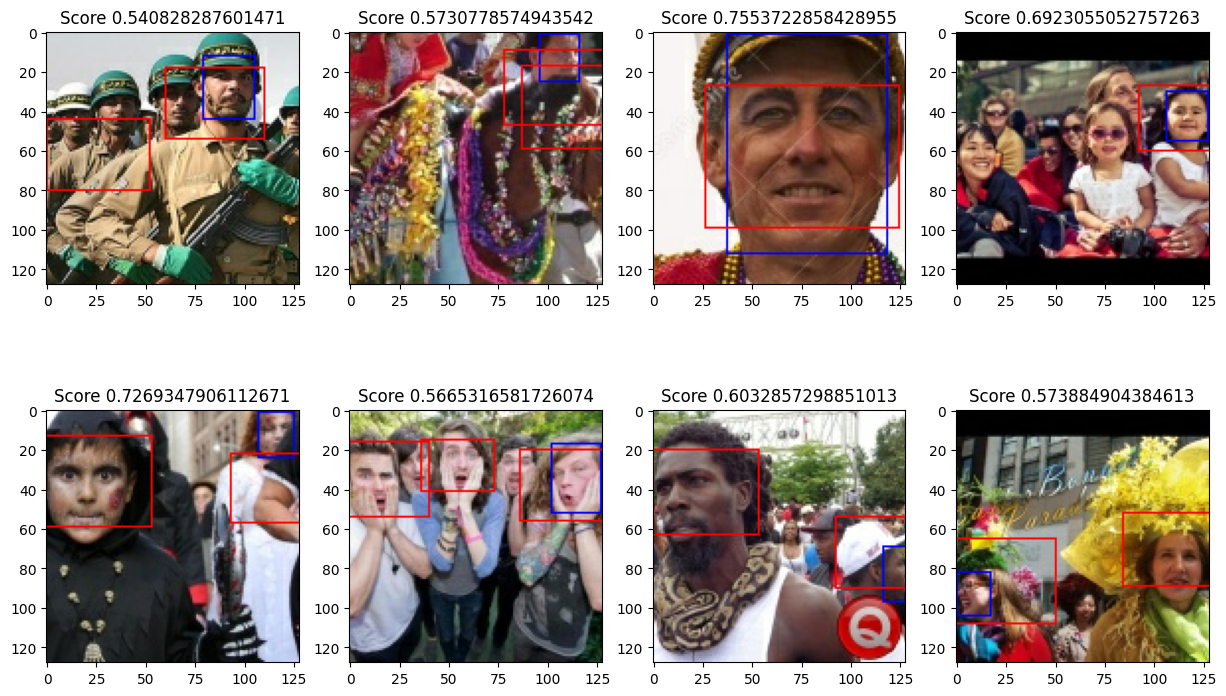

In [74]:
import matplotlib.pyplot as plt
def test_model(output_detections, predicted_output_detections, imgs, size=8):
  fig, ax = plt.subplots(2, 4, figsize=(15, 9))

  for index in range(size):
    y = 0 if index < 4 else 1
    x = index if index < 4 else index - 4

    true_boxes = output_detections[index]
    pred_boxes = predicted_output_detections[index]
    img = imgs[index].numpy()

    for box in true_boxes:
      x1 = int(box[1] * 128)
      y1 = int(box[2] * 128)
      x2 = int(box[3] * 128)
      y2 = int(box[4] * 128)
      color = (0, 0, 255)

      img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)

    score = 1

    if pred_boxes != []:
      for box in pred_boxes:
        score = box[0]
        x1 = int(box[1] * 128)
        y1 = int(box[2] * 128)
        x2 = int(box[3] * 128)
        y2 = int(box[4] * 128)
        color = (255, 0, 0)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)

    ax[y, x].imshow(img)
    ax[y, x].set_title('Score {}'.format(score))

model = tf.keras.models.load_model(
    "weights/saved_model/face.keras",
    custom_objects={"BlazeModel": BlazeModel}
)

for image_paths, imgs, big_anchors, small_anchors in test_generator:
  break

output_detections, predicted_output_detections = get_final_boxes(imgs, big_anchors, small_anchors, reference_anchors, model)
test_model(output_detections[0:8], predicted_output_detections[0:8], imgs[0:8])

 # 3D Face Landmark model

# AU classificator